In [ ]:
# Download the data (10 percent of food classes from food 101)
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-02-21 18:26:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 2607:f8b0:4023:c0b::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   193MB/s    in 0.8s    

2024-02-21 18:26:07 (193 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images do we have in each data

import os

# Walk through the data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/gri

### Creating data loaders (Preparing the data)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMG_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size= BATCH_SIZE,
                                             class_mode="categorical")



Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks

* Tracking experiments with tensorboard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model training with EarlyStopping callback

In [ ]:
# Creating Tensorboard callback (function)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback

##### Comparing resnet model vs efficientnet model

In [ ]:
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/101-classification/versions/2"
efficientnet_url = "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-feature-vector/versions/2"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Making a function to create a model from url

def create_model(model_url, num_classes=10):
  """
  Takes a tesorflow hub url and creates a Keras Sequential model with it

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer
    should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model_url as feature extractor layer
    and Dense output layer with num_classes output neurons.
  """
  # Download pretrained model as save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMG_SHAPE+(3,)) # Freeze already learned patterns
  # Create our Sequential model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Create ResNet feature extraction model

In [ ]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data.num_classes)

In [ ]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Fitting the model
history_resnet = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name= "resnet_50")])

Saving Tensorboard log files to: tensorflow_hub/resnet_50/20240221-182937
Epoch 1/5
24/24 [==============================] - 40s 1s/step - loss: 2.0533 - accuracy: 0.4267 - val_loss: 1.0694 - val_accuracy: 0.6472
Epoch 2/5
24/24 [==============================] - 16s 693ms/step - loss: 0.9461 - accuracy: 0.6960 - val_loss: 0.8273 - val_accuracy: 0.7140
Epoch 3/5
24/24 [==============================] - 17s 715ms/step - loss: 0.6708 - accuracy: 0.7933 - val_loss: 0.7625 - val_accuracy: 0.7336
Epoch 4/5
24/24 [==============================] - 16s 701ms/step - loss: 0.5147 - accuracy: 0.8493 - val_loss: 0.7110 - val_accuracy: 0.7572
Epoch 5/5
24/24 [==============================] - 16s 698ms/step - loss: 0.4104 - accuracy: 0.8813 - val_loss: 0.7224 - val_accuracy: 0.7496


In [ ]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1001)              44677609  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 44687629 (170.47 MB)
Trainable params: 10020 (39.14 KB)
Non-trainable params: 44677609 (170.43 MB)
_________________________________________________________________


In [ ]:
efficient_model = create_model(efficientnet_url,
                               num_classes=train_data.num_classes)

In [ ]:
efficient_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

history_eff = efficient_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name= "efficient")])

Saving Tensorboard log files to: tensorflow_hub/efficient/20240221-183137
Epoch 1/5
24/24 [==============================] - 22s 577ms/step - loss: 2.0371 - accuracy: 0.3013 - val_loss: 1.6005 - val_accuracy: 0.5648
Epoch 2/5
24/24 [==============================] - 14s 586ms/step - loss: 1.3488 - accuracy: 0.6613 - val_loss: 1.1721 - val_accuracy: 0.6952
Epoch 3/5
24/24 [==============================] - 12s 522ms/step - loss: 1.0231 - accuracy: 0.7560 - val_loss: 0.9808 - val_accuracy: 0.7384
Epoch 4/5
24/24 [==============================] - 13s 579ms/step - loss: 0.8535 - accuracy: 0.8000 - val_loss: 0.8778 - val_accuracy: 0.7552
Epoch 5/5
24/24 [==============================] - 11s 478ms/step - loss: 0.7415 - accuracy: 0.8280 - val_loss: 0.8131 - val_accuracy: 0.7660


### Creating a plot loss func

In [ ]:
import matplotlib.pyplot as plt

# Plot validation and training curves

def plot_loss_curves(history):
  """
  PLots the validation, loss and accuracy score for training
  and validation models.
  Args:
    history: TensorFlow History object.

  Returns:
    Plots of Training/validation loss and accuracy metrics
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("Epochs")
  plt.legend();


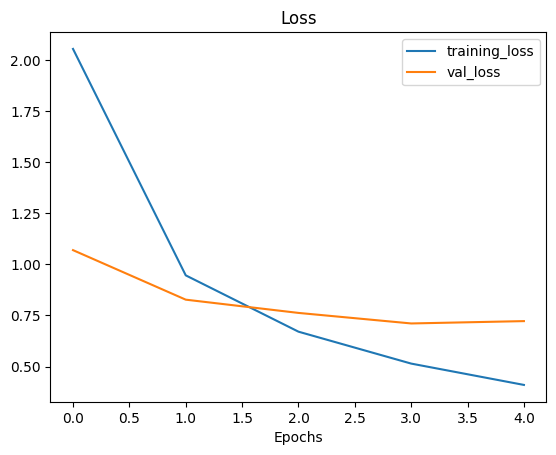

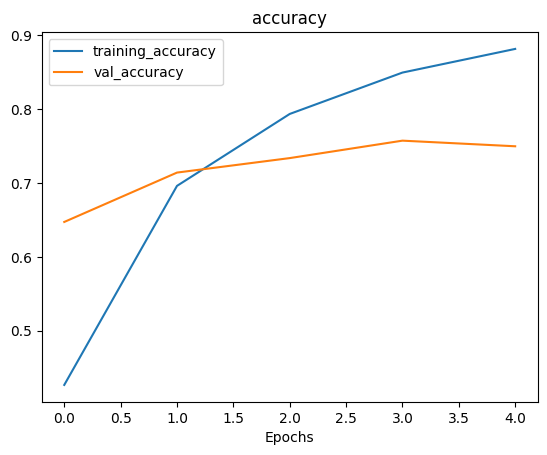

In [ ]:
plot_loss_curves(history_resnet)

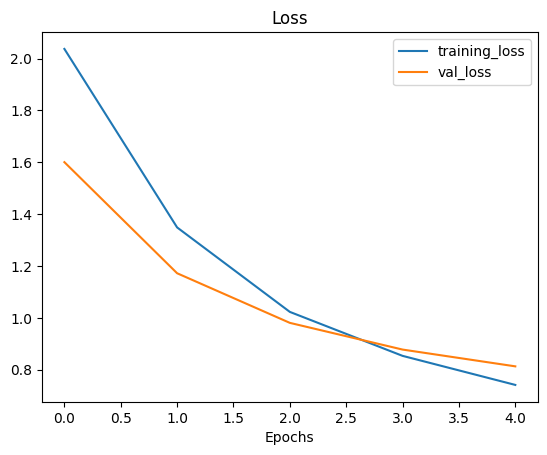

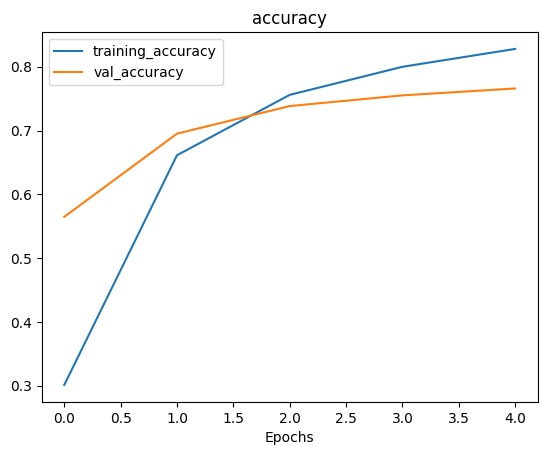

In [ ]:
plot_loss_curves(history_eff)

In [ ]:
efficient_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              5919312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


## Comparing results using TensorBoard

* Tensorboard makes infrormation public, not suitable for private data

In [ ]:
# Upload tensorflow dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "Efficient vs. resnest_50" \
  --description "Comapring two TF Hub model feature extractions using 10% of Food101" \
  --one_shot

2024-02-21 19:21:48.832145: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 19:21:48.832211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 19:21:48.833741: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 19:21:49.929103: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb